<a href="https://colab.research.google.com/github/vietnguyen012/Track/blob/master/Main_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I. Set up environment

- Load data via URL

In [58]:
!gdown https://drive.google.com/uc?id=1OCF_6ZblqfmUjI8spsa85l1JKLXqiQFq
!unzip -q fer2013.zip
!rm fer2013.zip

Downloading...
From: https://drive.google.com/uc?id=1OCF_6ZblqfmUjI8spsa85l1JKLXqiQFq
To: /content/fer2013.zip
63.3MB [00:02, 24.2MB/s]
replace test/angry/PrivateTest_10131363.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: All


- Load data via directory

In [3]:
!unzip /content/drive/MyDrive/fer2013.zip

unzip:  cannot find or open /content/drive/MyDrive/fer2013.zip, /content/drive/MyDrive/fer2013.zip.zip or /content/drive/MyDrive/fer2013.zip.ZIP.


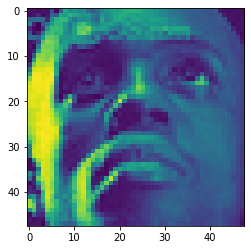

In [59]:
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import torch
from torchvision import datasets, transforms
import numpy as np
%matplotlib inline
image = Image.open('/content/train/neutral/Training_10002154.jpg')
image = np.asarray(image)/255
plt.imshow(image)

a sample image from dataset

In [60]:
image

array([[0.05490196, 0.05882353, 0.03921569, ..., 0.05098039, 0.0627451 ,
        0.05098039],
       [0.03529412, 0.06666667, 0.1254902 , ..., 0.06666667, 0.05098039,
        0.05490196],
       [0.32941176, 0.34509804, 0.36862745, ..., 0.05882353, 0.05098039,
        0.0627451 ],
       ...,
       [0.04313725, 0.32156863, 0.14117647, ..., 0.19607843, 0.16862745,
        0.10196078],
       [0.07058824, 0.04313725, 0.0627451 , ..., 0.16862745, 0.14117647,
        0.0745098 ],
       [0.05490196, 0.05882353, 0.07843137, ..., 0.15686275, 0.1372549 ,
        0.04705882]])

In [61]:

train_transform = transforms.Compose([transforms.Grayscale(),
                                      transforms.RandomCrop(48, padding=4, padding_mode='reflect'), 
                                      transforms.ColorJitter(brightness=0.5, contrast=0.5),
                                      transforms.RandomAffine(
                                           degrees=30,
                                           translate=(0.01, 0.12),
                                           shear=(0.01, 0.03),
                                       ),
                                       transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])

data = datasets.ImageFolder('/content/train', transform=transform)

In [62]:
data[0][0]

tensor([[[0.1961, 0.1255, 0.0588,  ..., 0.5216, 0.5922, 0.3373],
         [0.2235, 0.1333, 0.0863,  ..., 0.5412, 0.5922, 0.3490],
         [0.2392, 0.1176, 0.0941,  ..., 0.5569, 0.5843, 0.3490],
         ...,
         [0.4039, 0.3922, 0.3922,  ..., 0.5843, 0.4078, 0.3333],
         [0.4196, 0.4353, 0.4431,  ..., 0.5922, 0.4706, 0.3373],
         [0.4078, 0.4078, 0.4392,  ..., 0.5608, 0.5333, 0.3255]]])

total samples of training data

In [63]:
len(data)

28709

In [64]:
data.class_to_idx

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [65]:
from torch.utils.data import DataLoader
data_loader = DataLoader(data, batch_size=32, shuffle=True, num_workers=2)

In [66]:
it = iter(data_loader)
first_batch = next(it)
first_batch[0].size(),first_batch[1].size()

(torch.Size([32, 1, 48, 48]), torch.Size([32]))

given mean and standard deviation of the distribution, we used random sample to 
sample a tensor from the distribution

In [67]:
def noise_sample(mean,stddev):
  dist = Normal(mean,stddev)
  sample = dist.rsample()
  return sample

# II. Autoencoder

this is the encoder block of the autoencoder

In [68]:
import torch
import torch.nn as nn
class Encoder(nn.Module):
  def __init__(self,in_channel=1,output_channel=7,hidden_dim=16):
    super(Encoder,self).__init__()
    self.z_dim = output_channel
    self.disc = nn.Sequential(
        self.make_disc_block(in_channel,hidden_dim),
        self.make_disc_block(hidden_dim,hidden_dim*2),
        self.make_disc_block(hidden_dim*2,output_channel*2,final_layer=True)
    )
    self.fc = nn.Linear(14,14)
  def make_disc_block(self,input_channels,out_channels,kernel=7,stride=2,final_layer=False):
    if final_layer is False:
      return nn.Sequential(nn.Conv2d(input_channels,out_channels,kernel,stride),
                           nn.BatchNorm2d(out_channels),
                           nn.LeakyReLU(0.2,inplace=True),)
    else:
      return nn.Sequential(nn.Conv2d(input_channels,out_channels,kernel,stride))
  def forward(self,image):
    disc_pred = self.disc(image)
    encoding = disc_pred.view(len(disc_pred),-1) # 32,14
    output = self.fc(encoding)
    return output[:,:self.z_dim].clone(),output[:,self.z_dim:].clone().exp()

In [69]:
#test
from torch.distributions.normal import Normal
image = torch.randn(32,1,48,48)
vae_encoder = Encoder(in_channel=1)
mean,stddev = vae_encoder(image)
sample = noise_sample(mean,stddev)
sample.size()

torch.Size([32, 7])

use class PrintLayer to debug mismatched sizes in Sequential layers

In [70]:
#for debug
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.size())
        return x

this is the decoder block of autoencoder

In [71]:
class Decoder(nn.Module):
  def __init__(self,z_dim = 7,im_chan=1,hidden_dim=64):
    super(Decoder,self).__init__()
    self.z_dim = z_dim
    self.gen = nn.Sequential(
        self.make_gen_block(z_dim,hidden_dim*4),
        self.make_gen_block(hidden_dim*4,hidden_dim*2,kernel=2,stride=2),
        self.make_gen_block(hidden_dim*2,hidden_dim,kernel=2,stride=2),
        self.make_gen_block(hidden_dim,im_chan,kernel=2,stride=2,final_layer=True),
    )

  def make_gen_block(self,input_channels,output_channels,kernel=6,stride=2,final_layer=False):
      if not final_layer:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels,output_channels,kernel,stride),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True),
        )
      else:
        return nn.Sequential(
            nn.ConvTranspose2d(input_channels,output_channels,kernel,stride),
            nn.Sigmoid(),
        )
  def forward(self,noise):
    x = noise.view(len(noise),self.z_dim,1,1) 
    return self.gen(x)
 

In [72]:
#test 
noise = torch.rand(12,7)
decoder = Decoder()
out = decoder(noise)
out.size()

torch.Size([12, 1, 48, 48])

class autoencoder

In [73]:
from torch.distributions.normal import Normal
class VAE(nn.Module):
  def __init__(self,z_dim=7,im_chan=1,hidden_dim=64):
    super(VAE,self).__init__()
    self.z_dim = z_dim
    self.encode = Encoder(im_chan,z_dim)
    self.decode = Decoder(z_dim,im_chan)
  def forward(self,images):
    q_mean,q_stddev = self.encode(images)
    q_dist = Normal(q_mean,q_stddev)
    z_sample = q_dist.rsample()
    decoding = self.decode(z_sample) + images
    return decoding,q_dist,z_sample

this is the kl-divergence loss between random sample drawn from output of encoder and the the normal distribution. This loss used to reduced overfit of autoencoder and normalize the output's encoder to Normal distribution. 

$$
\Large q_\lambda^*(z | x) = argmin_\lambda KL(q_\lambda(z | x) \; || \; p(z | x))
$$

In [74]:
reconstruction_loss = nn.BCELoss(reduction='sum')
from torch.distributions.kl import kl_divergence
from torch.distributions import Categorical
def kl_divergence_loss(q_dist):
  return kl_divergence(
        q_dist, Normal(torch.zeros_like(q_dist.mean), 
                       torch.ones_like(q_dist.stddev))
    ).sum(-1)

# III. FCM


this kl-divergence (22) uses membership matrix qij to approximate student's-t Distribution pij in DEC,IDEC structures


$$
\Large \min KL(P||Q) = \min \sum_{i=1}^N \sum_{j=1}^c p_{ij}\log\frac{p_{ij}}{q_{ij}} \qquad (22)
$$ 

In [75]:
def KL_divergence(p,q):
  p =Categorical(probs=p)
  q= Categorical(probs=q)
  return kl_divergence(p,q).sum(-1)

The desired target pij of the Student’s-t based membership qij
is defined with (12), which increases the variance of qij and
normalizes qij with respect of the jth center .

$$
\Large p_{ij} = \frac{q_{ij}^2 / \sum_{i}q_{ij}}
{\sum_{k=1}^{c}(q_{ik}^2 / \sum_{i}q_{ik})}, 
\quad \sum_{j=1}^{c}p_{ij} = 1, \, \forall{i} \qquad (12)
$$ 

In [76]:
def calculate_p(q):
  w = (q**2/torch.sum(q,0))
  return (w.t()/torch.sum(w,1).t()).t()

Minimzing Fuzzy cluster compactness equivalent to minimize within class scatter matrix and maximize between class matrix.From this objective, fuzzy membership qij is given by (21)

$$
\Large q_{ij} = \frac{(\|z_{i} - \mu_{j}\|^2 - \frac{\beta}{\sum_{k=1}^{c}\|\mu_{k} - \overline{\mu}\|^2}\|\mu_{j} - \overline{\mu}\|^2)^{-1/(m-1)}}
{\sum_{k=1}^{c}(\|z_{i} - \mu_{k}\|^2 - \frac{\beta}{\sum_{k=1}^{c}\|\mu_{k} - \overline{\mu}\|^2}\|\mu_{k} - \overline{\mu}\|^2)^{-1/(m-1)}} \qquad (21)
$$ 

In [105]:
def calculate_q(z,cluster_number):
  batch_size,embedding_dimension = z.size() 
  beta = 0.0007
  m = 0.5
  power = -1/(m-1)
  initial_cluster_center = torch.zeros(cluster_number,embedding_dimension,dtype=torch.float).to(z.device)
  nn.init.xavier_uniform_(initial_cluster_center)
  cluster_center = nn.Parameter(initial_cluster_center)
  norm_squared = torch.sum((z.unsqueeze(1)-cluster_center)**2,2)
  norm_squared_mu = torch.sum((cluster_center - cluster_center.mean())**2,1)
  numerator = (norm_squared-beta/torch.sum(norm_squared_mu)*norm_squared_mu)*power
  q = numerator/torch.sum(numerator,dim=1,keepdim=True)
  return q

Define label li,lv are pseudo labels of the maximum value's index of the datapoint with coresponding the C cluster, taking datapoints zi,zv we calculate the affinity between the datapoints when it has the same pseudo-labels or 0 otherwise

$$
\Large s_{iv} = 
\begin{cases} 
  \exp(-\|z_{i} - z_{v}\|^2 / \sigma) / t, \quad l_i = l_v
  \\\\
  0, \quad l_i \ne l_v
\end{cases}
\qquad (28)
$$

In [78]:
def repeat(tensor, dims):
    if len(dims) != len(tensor.shape):
        raise ValueError("The length of the second argument must equal the number of dimensions of the first.")
    for index, dim in enumerate(dims):
        repetition_vector = [1]*(len(dims)+1)
        repetition_vector[index+1] = dim
        new_tensor_shape = list(tensor.shape)
        new_tensor_shape[index] *= dim
        tensor = tensor.unsqueeze(index+1).repeat(repetition_vector).reshape(new_tensor_shape)
    return tensor

In [79]:
def calculate_affinity(q,z):
  batch,_ = q.size()
  s_iv = torch.zeros(batch,batch).to(z.device)
  labels = torch.argmax(q,axis=1)
  sigma = 1
  t = 2
  for i in range(batch):
    for v in range(batch):
      if labels[i] == labels[v]:
        s_iv[i,v] = torch.exp(-torch.linalg.norm(z[i]-z[v])**2/sigma)/t
      else:
        s_iv[i,v] = 0
  return s_iv,labels 


Graph based regularization on hidden features with the assumption that the input data should be consistent with the ones in new representation (for example Z-representation). If the affinity of xi and xv is high then the distance between zi and zv must be low, on the other hand, if affinity of xi and xv is low like zero then the distance between zi and zv can be large . 

$$
\Large \min G_z = \min \sum_{i,v=1}^{N} \|z_i - z_v\|^{2} s_{iv}
$$

In [80]:
def graph_based_reg(q,z,s_iv,calculate_siv):
  batch,_ = q.size()
  if calculate_siv:
      s_iv,pseudo_label =  calculate_affinity(q,z)
  else:
      pseudo_label=torch.argmax(q,axis=1)
  z_i = repeat(z,[batch,1])
  z_v = torch.tile(z, (batch,1))
  l_graph_based_reg = torch.sum(torch.linalg.norm(z_i-z_v,dim=1)*s_iv.flatten())
  return l_graph_based_reg, s_iv,pseudo_label

# IV. Define and Train Model

The architecture of autoecnoder

In [88]:
class AutoEncoder(nn.Module):

    def __init__(self, z_dims=512, in_channels=1, hid_channels=32):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            self.conv_block(in_channels, hid_channels),
            self.conv_block(hid_channels, hid_channels*2),
            self.conv_block(hid_channels*2, hid_channels*4),     
            self.conv_block(hid_channels*4, hid_channels*8),
            nn.Conv2d(hid_channels*8, hid_channels*2, 1, 1)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(3*3*hid_channels*2, z_dims)
            # nn.ReLU(),
            # nn.Linear(1024, z_dims)
        )

        self.fc2 = nn.Sequential(
            # nn.Linear(z_dims, 1024),
            # nn.ReLU(),
            nn.Linear(z_dims, 3*3*hid_channels*2)
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(hid_channels*2, hid_channels*8, 1, 1),
            self.deconv_block(hid_channels*8, hid_channels*4),     
            self.deconv_block(hid_channels*4, hid_channels*2),
            self.deconv_block(hid_channels*2, hid_channels),
            nn.ConvTranspose2d(hid_channels, in_channels, 2, 2),
            nn.Sigmoid()
        )

    def conv_block(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
            # nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            # nn.BatchNorm2d(out_channels),
            # nn.ReLU()   
        )

    def deconv_block(self, in_channels, out_channels, kernel_size=2, stride=2, padding=0):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding=padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
            # nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
            # nn.BatchNorm2d(out_channels),
            # nn.ReLU()   
        )

    def forward(self, image):
        x = self.encoder(image)
        x = x.view(len(x), -1)
        latent_space = self.fc1(x)
        x = self.fc2(latent_space)
        x = x.view(len(x), -1, 3, 3)
        x = self.decoder(x)
        return x,latent_space

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

ae = AutoEncoder().to(device)
ae = torch.load('/content/drive/MyDrive/AutoEncoder_v1.pt')
print(model)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999))


cuda:0
AutoEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (fc1): Sequential(
    (0): Linea

In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
device = 'cuda'
vae = VAE().to(device)
vae.eval()

VAE(
  (encode): Encoder(
    (disc): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(2, 2))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (2): Sequential(
        (0): Conv2d(32, 14, kernel_size=(7, 7), stride=(2, 2))
      )
    )
    (fc): Linear(in_features=14, out_features=14, bias=True)
  )
  (decode): Decoder(
    (gen): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(7, 256, kernel_size=(6, 6), stride=(2, 2))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
  

Algorithm 1: the algorithm for graph regularized deep normalized fuzzy compactness separation clustering 

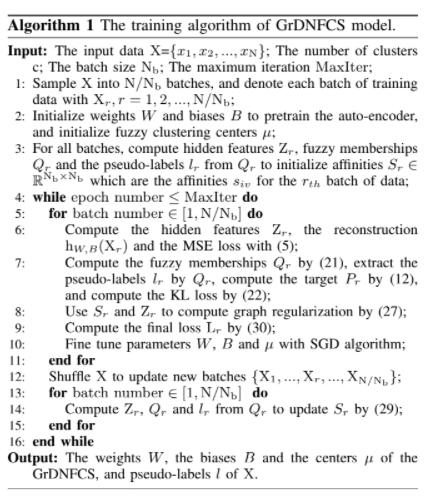

In [91]:
plt.rcParams["figure.figsize"] = (16, 8)

from torchvision.utils import make_grid
from tqdm import tqdm
import time
num_class=7
alpha1 = 0.5
alpha2 = 0.2
batch=32

prediction_n_ground = []
S = []
vae_opt = torch.optim.Adam(vae.parameters(), lr=0.002)


Pre-train autencoder

Epoch 0


100%|██████████| 898/898 [00:10<00:00, 88.97it/s]


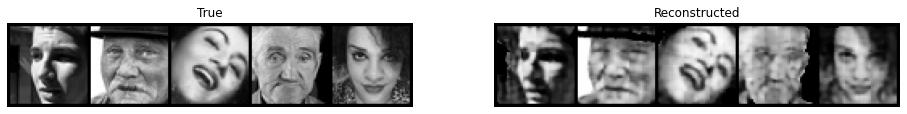

Epoch 1


100%|██████████| 898/898 [00:10<00:00, 89.42it/s]


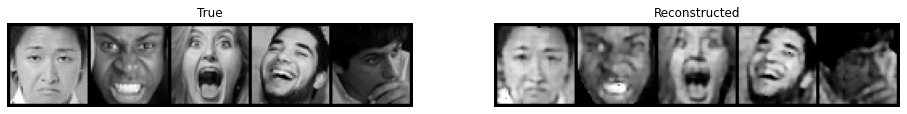

Epoch 2


100%|██████████| 898/898 [00:10<00:00, 89.79it/s]


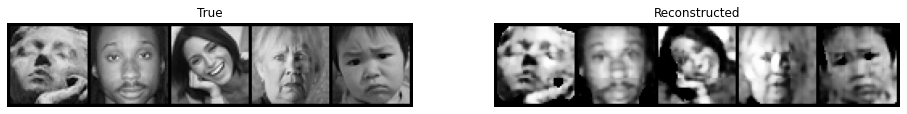

Epoch 3


100%|██████████| 898/898 [00:10<00:00, 89.50it/s]


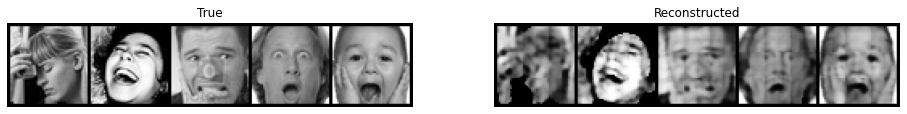

Epoch 4


100%|██████████| 898/898 [00:10<00:00, 87.76it/s]


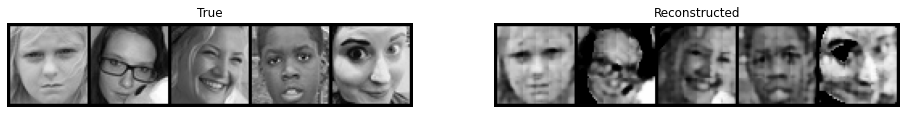

Epoch 5


100%|██████████| 898/898 [00:10<00:00, 88.10it/s]


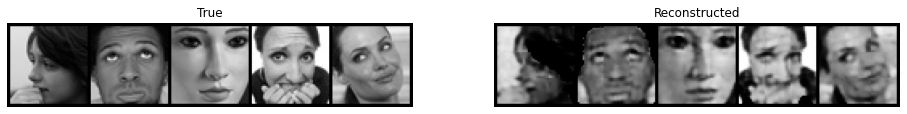

Epoch 6


100%|██████████| 898/898 [00:10<00:00, 87.75it/s]


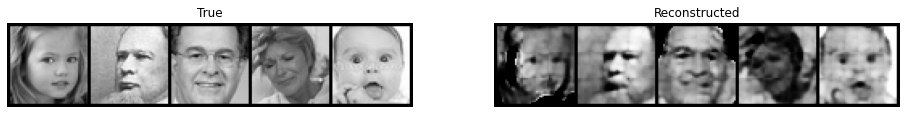

Epoch 7


100%|██████████| 898/898 [00:10<00:00, 85.82it/s]


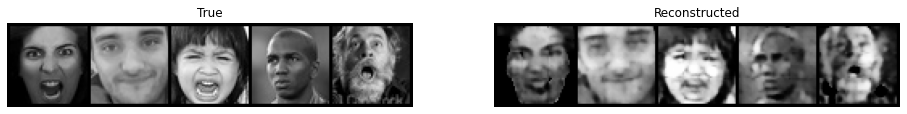

Epoch 8


100%|██████████| 898/898 [00:10<00:00, 83.58it/s]


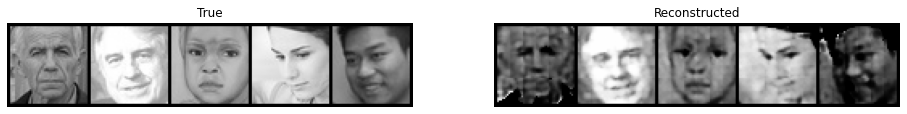

Epoch 9


100%|██████████| 898/898 [00:10<00:00, 85.91it/s]


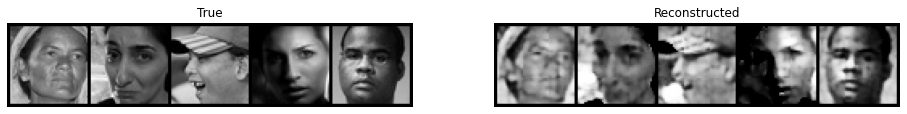

In [93]:

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.axis('off')
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
#pre-train vae
for epoch in range(10):
    print(f"Epoch {epoch}")
    time.sleep(0.5)
    for images,_ in tqdm(data_loader,position=0, leave=True): 
        optimizer.zero_grad() # Clear out the gradients
        images = images.to(device)
        recon_images,z_features = ae(images)
        pre_trained_loss = reconstruction_loss(recon_images, images) 
        # kl_divergence_loss(encoding).sum()
        pre_trained_loss.backward()
        optimizer.step()
    plt.subplot(1,2,1)
    show_tensor_images(images)
    plt.title("True")
    plt.subplot(1,2,2)
    show_tensor_images(recon_images)
    plt.title("Reconstructed")
    plt.show()

Initilize parameters

In [106]:
#step 3 initialize
device ='cuda'
for images,_ in tqdm(data_loader,position=0,leave=True): 
        ae.eval()
        with torch.no_grad():
            s_iv = torch.zeros((batch,batch))
            images = images.to(device)
            optimizer.zero_grad() # Clear out the gradients
            _, z_features = ae(images)
            # weight_mean,weight_stddev = vae.encode.fc.weight[:num_class,:num_class],vae.encode.fc.weight[num_class:,num_class:].exp()
            # mu_weight = noise_sample(weight_mean,weight_stddev)
            q = calculate_q(z_features,7)
            _,s_iv,p_label = graph_based_reg(q,z_features,s_iv,True)
            S.append(s_iv)

100%|██████████| 898/898 [01:03<00:00, 14.04it/s]


In [113]:
def accuracy(preds,gts):
  correct = 0 
  total = 0
  for pred,gt in zip(preds,gts):
    total += gt.size(0)
    correct += (gt==pred).sum()
  return correct/total

Train the whole model

In [ ]:
torch.autograd.set_detect_anomaly(True)
#step 4 train
for epoch in range(10):
    print(f"Epoch {epoch}")
    ae.train()
    time.sleep(0.5)
    for r,(images,_) in enumerate(tqdm(data_loader,position=0,leave=True)): 
        images = images.to(device)
        S_r=S[r].to(device)
        optimizer.zero_grad() # Clear out the gradients
        recon_images, z_features = ae(images)
        # encoding
        # weight_mean,weight_stddev = vae.encode.fc.weight[:num_class,:num_class].clone(),vae.encode.fc.weight[num_class:,num_class:].clone().exp()
        # mu_weight = noise_sample(weight_mean,weight_stddev)
        q = calculate_q(z_features,7)
        p = calculate_p(q)
        loss_graph_based_reg,_,_ = graph_based_reg(q,z_features,S_r,False)
        # + kl_divergence_loss(encoding).sum() 
        loss = reconstruction_loss(recon_images, images) + alpha1*KL_divergence(p,q) + alpha2*loss_graph_based_reg
        loss.backward(retain_graph=True)
        optimizer.step()
    preds = []
    gts = []
    ae.eval()
    for r,(images,ground_truth) in enumerate(tqdm(data_loader,position=0,leave=True)):
        images = images.to(device)
        optimizer.zero_grad() # Clear out the gradients
        recon_images,z_features = ae(images)
        # weight_mean,weight_stddev = vae.encode.fc.weight[:num_class,:num_class].clone(),vae.encode.fc.weight[num_class:,num_class:].clone().exp()
        # mu_weight = noise_sample(weight_mean,weight_stddev)
        q = calculate_q(z_features,7)
        _,s_iv,p_label = graph_based_reg(q,z_features,S[r].to(device),True)

        preds.append(p_label.squeeze(0))
        gts.append(ground_truth.squeeze(0))
    acc = accuracy(preds,gts)
    print('accuracy:',acc)
    plt.subplot(1,2,1)
    show_tensor_images(images)
    plt.title("True")
    plt.subplot(1,2,2)
    show_tensor_images(recon_images)
    plt.title("Reconstructed")
    plt.show()


Epoch 0


 29%|██▉       | 262/898 [07:33<17:57,  1.69s/it]

# V. Visualization

Plot show distribution of datapoints in each class

In [ ]:
# Visualize sample with seaborn
def plot_latent(model,data_loader,num_batches=100):
  import seaborn as sns
  import pandas as pd

  device = 'cuda'
  x,y = next(iter(data_loader))
  mean,stddev = model.encode(x.to(device))
  dist = Normal(mean,stddev)
  sample = dist.rsample() 

  df = pd.DataFrame(sample.cpu().detach().numpy())
  df['label'] = y
  df['label'] = df['label'].astype('str')
  sns.pairplot(df, hue='label')


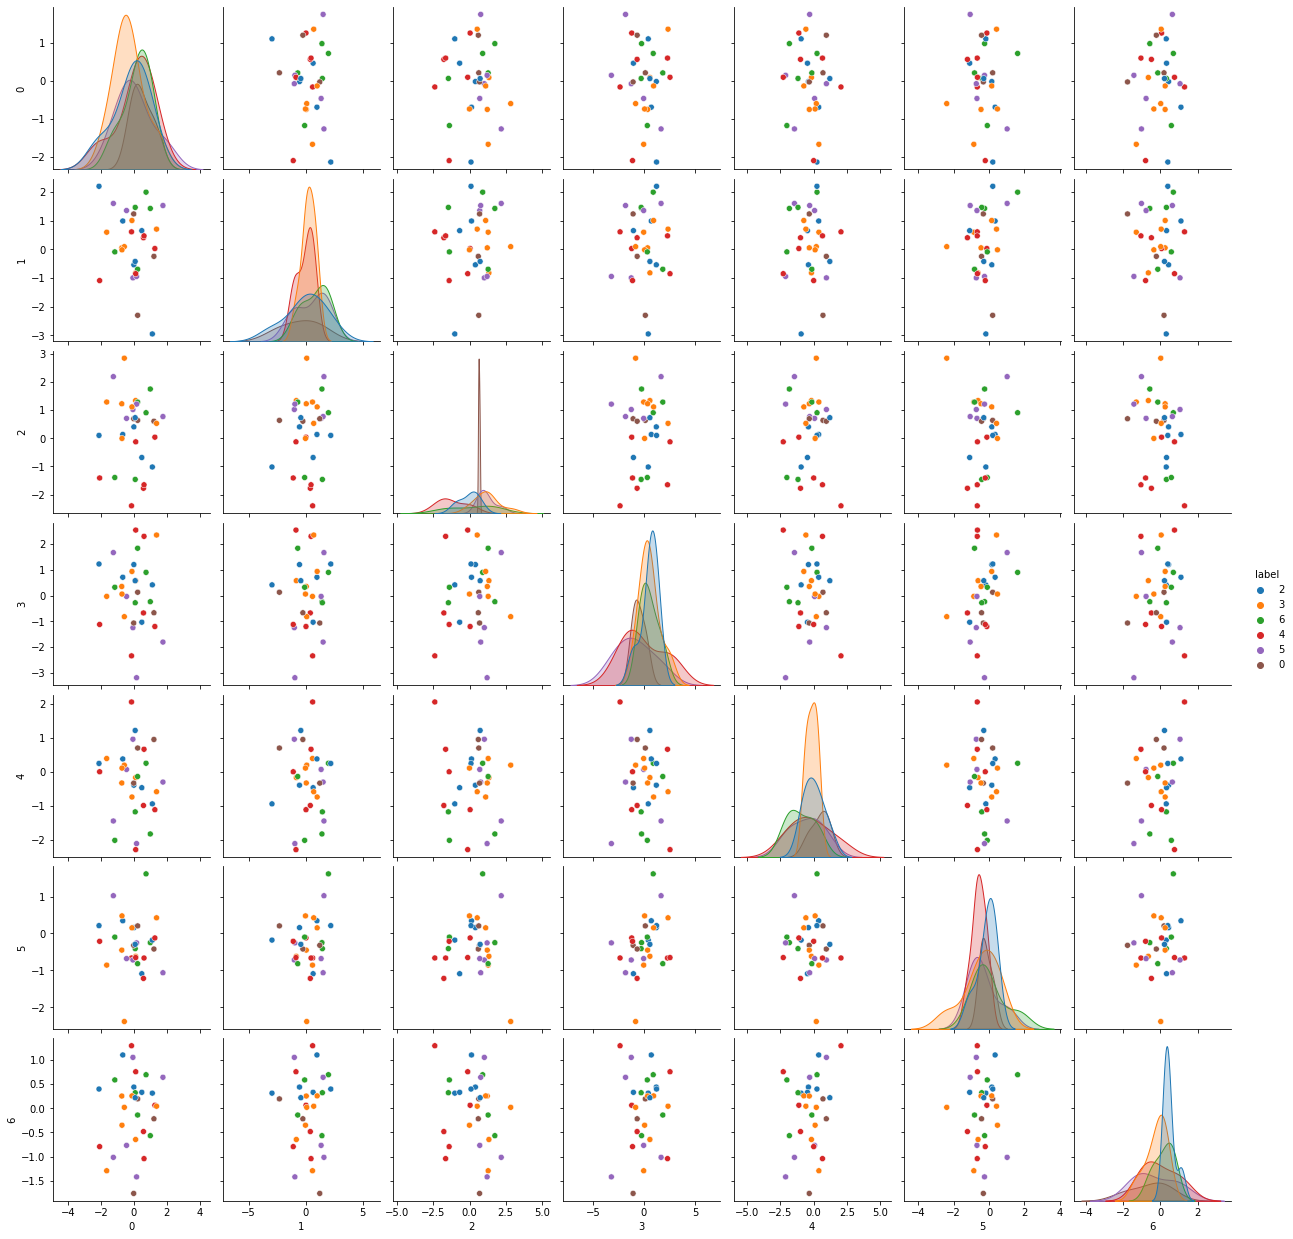

In [ ]:
plot_latent(vae, data_loader)

In [ ]:
# Visualize sample with plotly
def plot_latent(model,data_loader,num_batches=100):
  import plotly.express as px
  import pandas as pd

  device = 'cuda'
  x,y = next(iter(data_loader))
  mean,stddev = model.encode(x.to(device))
  dist = Normal(mean,stddev)
  sample = dist.rsample() 

  df = pd.DataFrame(sample.cpu().detach().numpy())
  df['label'] = y
  df['label'] = df['label'].astype('str')
  fig = px.scatter_matrix(df, dimensions=range(7), color="label")
  fig.show()


In [ ]:
plot_latent(vae, data_loader)